In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
import pyspatialml as pml
from pyspatialml import Raster
import rasterio as rio
from rasterio.plot import show
from sklearn import metrics
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from yellowbrick.classifier import classification_report
from yellowbrick.model_selection import ValidationCurve

In [4]:
# load in dataset
df_of_yes = pd.read_csv(r"C:\Users\JGrov\Desktop\High_Elevation_Fire_Refugia\YES_OF.csv")

# drop classifications from dataset
df_of_yes.drop(labels=['OF','Spruce_Cover'], axis=1, inplace=True)

# compute the square
df_of_yes['Solar_Radiation'] = df_of_yes['Solar_Radiation']**(1/2)

# lsit the statistics of the dataframe
df_of_yes.describe(include='all')

# export the descriptive statistics
# df_of_yes.describe(include='all').to_csv("my_description_v2.csv")

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 6 Text major ticklabel objects>)

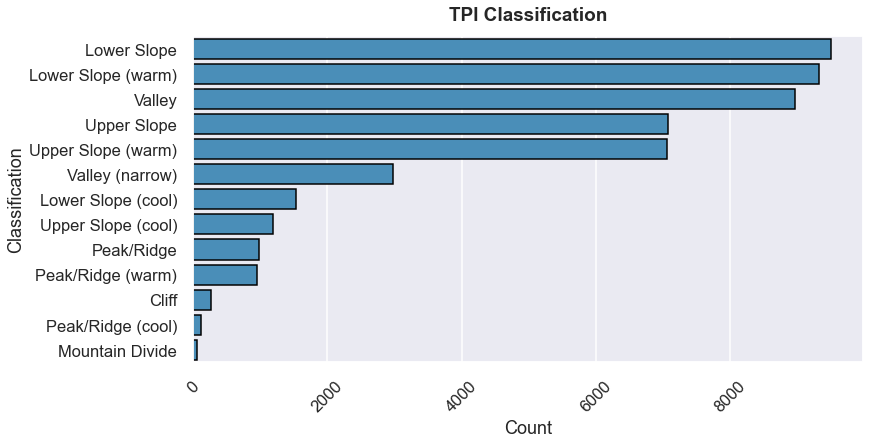

In [4]:
# load in the TPI dataset
df_tpi_class = pd.read_csv(r"C:\Users\JGrov\Desktop\Fire_Refugia_CO\Point_Data\tpi_class.csv")

# replace numeric values with strings
df_tpi_class = df_tpi_class.replace({32:'Lower Slope',
                            31:'Lower Slope (warm)',
                            41:'Valley',
                            22:'Upper Slope',
                            21:'Upper Slope (warm)',
                            42:'Valley (narrow)',
                            33:'Lower Slope (cool)',
                            23:'Upper Slope (cool)',
                            12:'Peak/Ridge',
                            11:'Peak/Ridge (warm)',
                            15:'Cliff',
                            13:'Peak/Ridge (cool)',
                            14:'Mountain Divide'})
# get the count of each class
df_tpi_count = df_tpi_class['Class'].value_counts().rename_axis('Class').reset_index(name='Count')

# plot the dataframe
plt.figure(figsize=(12,6))
sns.set(style='darkgrid')
sns.set_context('talk')

ax1 = sns.barplot(x='Count', y='Class', data=df_tpi_count, orient='h', color='#3792CB', edgecolor= 'black' ) 
plt.title('TPI Classification',
          weight='bold',
          y=1.03).set_fontsize('19')
plt.xlabel('Count')
plt.ylabel('Classification')
plt.xticks(rotation=45)


In [9]:
# read in data
of_yes = pd.read_csv(r"C:\Users\JGrov\Desktop\High_Elevation_Fire_Refugia\YES_OF.csv")
of_no = pd.read_csv(r"C:\Users\JGrov\Desktop\High_Elevation_Fire_Refugia\NO_OF.csv")

# append data in a single data frame
df = of_yes.append(of_no)

# # drop select columns and shuffle dataframe rows
df = df.sample(frac=1)

# create feature variables
X = df

# create target variables
y = X["OF"]

# seperate target from rest of features
X.drop(labels="OF", axis=1, inplace=True)

# replace the few NA values with 0
# X = X.fillna(0)

X

,Elevation,Burn_Probability,No_Fuel_1000m,No_Fuel_5000m,Spruce_Cover,Solar_Radiation,Stream_Distance,TPI_300m,TPI_2000m
13093,2585,0.001595,0.000000,0.000000,0,2.895654e+06,412.310577,-29.310303,8.897461
26819,2278,0.001000,0.000000,0.000000,0,2.087607e+06,600.000000,-18.310303,-58.680908
3815,3476,0.000000,0.088328,0.046399,1,2.476181e+06,424.264069,-13.724121,-129.770996
32680,3499,0.000000,0.293375,0.354621,0,2.645704e+06,824.621155,3.137939,99.507568
9524,3363,0.000100,0.157729,0.249458,1,2.923608e+06,282.842712,43.379395,-37.286377
...,...,...,...,...,...,...,...,...,...
756,1936,0.000799,0.000000,0.000000,0,2.877800e+06,282.842712,3.724121,42.793945
43928,3361,0.000100,0.059937,0.110516,1,2.242338e+06,943.398132,71.482666,243.305420
194,2391,0.003241,0.000000,0.002677,0,1.974992e+06,984.885803,26.758545,135.705566
43223,1445,0.000300,0.000000,0.000000,0,5.284233e+05,500.000000,-0.103394,3.255371


In [6]:
# split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, # 80% training and 20% test 
                                                    random_state=0, 
                                                    stratify=y) 

# create the xgb model object
xgb_model = xgb.XGBClassifier(objective='binary:logistic', 
                          missing=None, 
                          use_label_encoder=False)

# append model objects to a list
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNC', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('GBRT', xgb_model))

# loop through each model to run and print the accuracy score
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.761000 (0.005910)
LDA: 0.893175 (0.003219)
KNC: 0.897038 (0.002953)
GNB: 0.892962 (0.003306)
[09:54:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:54:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:54:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

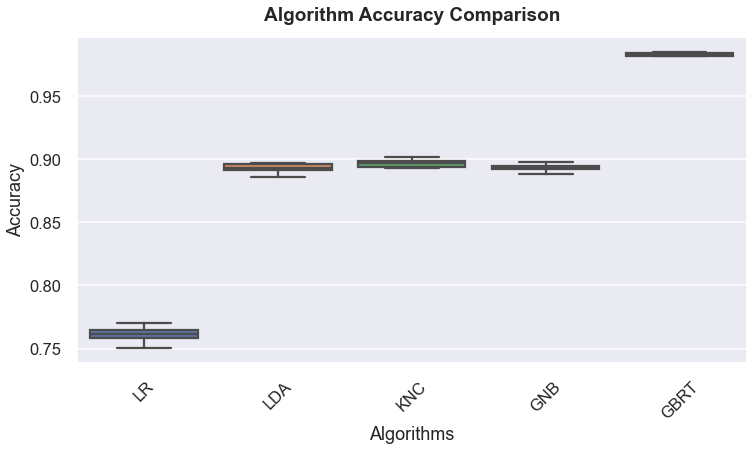

In [7]:
# plot algorithm comparison
plt.figure(figsize=(12,6))
sns.set(style='darkgrid')
sns.set_context('talk')

ax = sns.boxplot(x=names, y=results, showfliers = False)
plt.title('Algorithm Accuracy Comparison',
          weight='bold',
          y=1.03).set_fontsize('19')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)


In [10]:
# split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, # 80% training and 20% test 
                                                    random_state=0, 
                                                    stratify=y) 

# create the model object
model = xgb.XGBClassifier(objective='binary:logistic', 
                          missing=None, 
                          use_label_encoder=False)
# train the model
model.fit(X_train,
           y_train,
           verbose = False, 
           early_stopping_rounds=10,
           eval_metric = "aucpr",
           eval_set = [(X_test, y_test)])

# check the accuracy of the model
predictions = model.predict(X_test)
accuracy = accuracy_score(predictions, y_test)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.80%


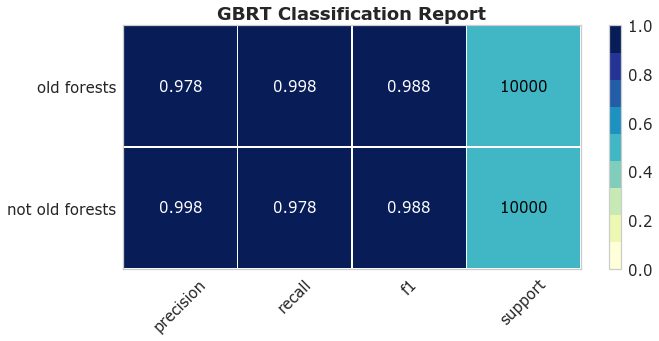

In [11]:
# create labels
labels = ['not old forests','old forests']

# plots classification report
def class_report(model, labels):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (10, 5),
             'axes.labelsize': 12,
             'axes.titlesize': 18,
             'axes.titleweight': 'bold',
             'xtick.labelsize': 15,
             'ytick.labelsize': 15,
             'font.size': 15,
             'font.family': 'Verdana'}
    plt.rcParams.update(params)
    
    classification_report(model, X_train, y_train, X_test, y_test, 
                                      classes=labels, 
                                      support=True, 
                                      title='GBRT Classification Report',
                                      cmap='YlGnBu')

class_report(model, labels)

In [86]:
# grid search parameters
# gs_cv_params = {
#     'max_depth': range (2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05]
# }

# searchs for best combination of parameters
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=gs_cv_params,
#     scoring = 'roc_auc',
#     n_jobs = 10,
#     cv = 10,
#     verbose=True
# )

# grid_search.fit(X, y)


# grid_search.best_estimator_

In [12]:
# create model object from new parameters
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=180, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# train model with new parameters
model.fit(X_train,
           y_train,
           verbose = False, 
           early_stopping_rounds=10,
           eval_metric = "aucpr",
           eval_set = [(X_test, y_test)])

# check accuarcy of new model
predictions = model.predict(X_test)
accuracy = accuracy_score(predictions, y_test)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.97%


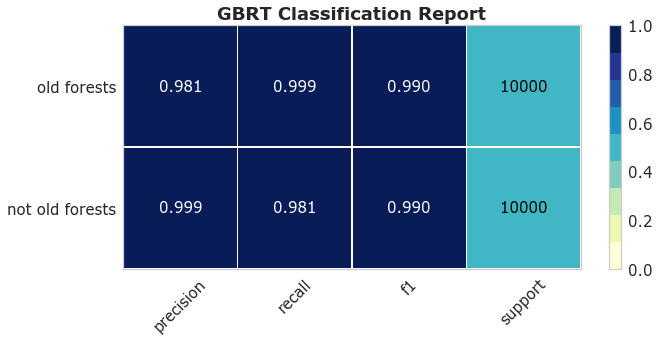

In [13]:
class_report(model, labels)

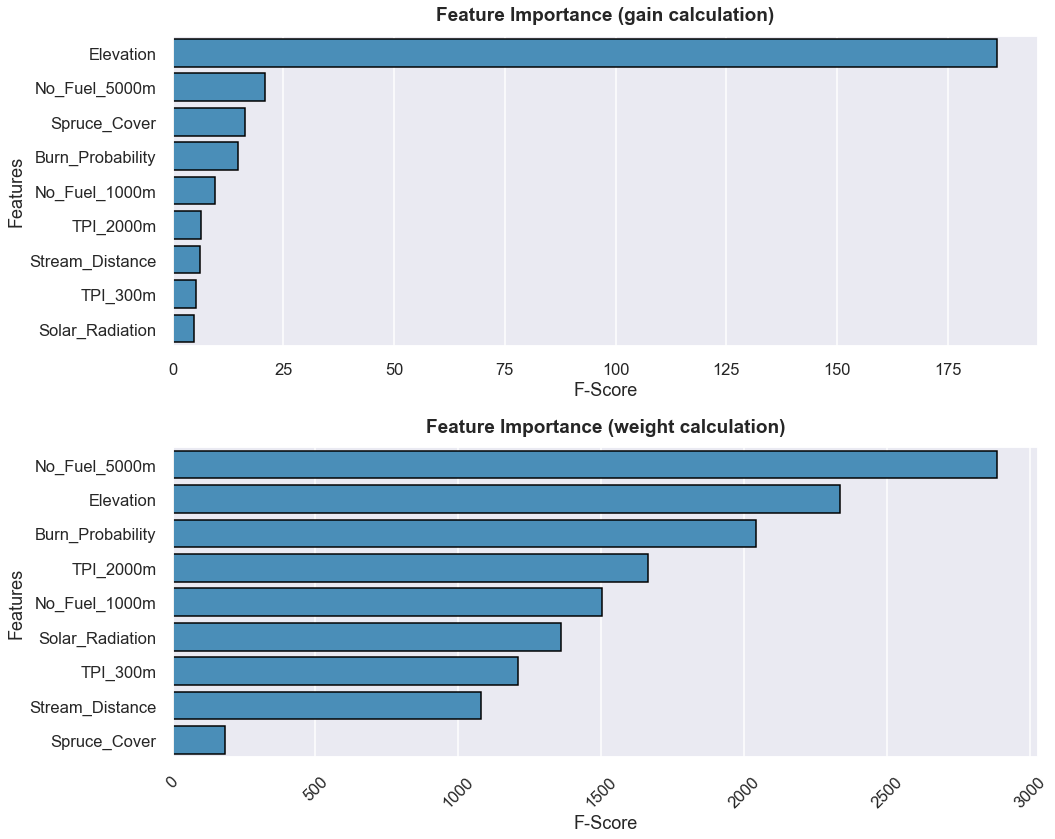

In [14]:
# Get the booster from the xgbmodel
booster = model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance_gain = booster.get_score(importance_type="gain")

df_importance_gain = pd.DataFrame.from_dict(importance_gain, orient='index').reset_index()
df_importance_gain.columns = ['Features', 'F-Score'] 
df_importance_gain = df_importance_gain.sort_values(by=['F-Score'], ascending=False )

# Get the importance dictionary (by weight) from the booster
importance_weight = booster.get_score(importance_type="weight")

df_importance_weight = pd.DataFrame.from_dict(importance_weight, orient='index').reset_index()
df_importance_weight.columns = ['Features', 'F-Score'] 
df_importance_weight = df_importance_weight.sort_values(by=['F-Score'], ascending=False )

# plot importance variables
sns.set(style='darkgrid')
sns.set_context('talk')

fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(15,12))
sns.barplot(x='F-Score', y='Features', data=df_importance_gain, orient='h', color='#3792CB', edgecolor= 'black', ax=ax1)
sns.barplot(x='F-Score', y='Features', data=df_importance_weight, orient='h', color='#3792CB', edgecolor= 'black', ax=ax2)

ax1.set_title('Feature Importance (gain calculation)',
          weight='bold',
          y=1.03).set_fontsize('19')
ax2.set_title('Feature Importance (weight calculation)',
          weight='bold',
          y=1.03).set_fontsize('19')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.xticks(rotation=45)
fig.tight_layout()

In [16]:
# visual parameters for graphviz
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

# graphs tree
graph_data = xgb.to_graphviz(model, 
                             num_trees=0, 
                             size="5,5!", 
                             condition_node_params=node_params, 
                             leaf_node_params=leaf_params)

graph_data 

# export graph
graph_data.format = 'png'
graph_data.view(filename='brt_HE_FR', directory=r'C:\Users\JGrov\Desktop')

'C:\\Users\\JGrov\\Desktop\\brt_HE_FR.png'

In [17]:
# reads in raster using pyspatialml package
r_preds = pml.Raster(r"C:\Users\JGrov\Desktop\Fire_Refugia_CO\Raster Data\model_composite.tif")

print(r_preds.names)

['model_composite_1', 'model_composite_2', 'model_composite_3', 'model_composite_4', 'model_composite_5', 'model_composite_6', 'model_composite_7', 'model_composite_8', 'model_composite_9']


In [18]:
# renames each raster layer in the composite to match the dataframe and must be in exact order and exact spelling
r_preds.rename({'model_composite_1':'Elevation',
                'model_composite_2':'Burn_Probability',
                'model_composite_3':'No_Fuel_1000m', 
                'model_composite_4':'No_Fuel_5000m',
                'model_composite_5':'Spruce_Cover',
                'model_composite_6':'Solar_Radiation',
                'model_composite_7':'Stream_Distance',
                'model_composite_8':'TPI_300m',
                'model_composite_9':'TPI_2000m'},in_place=True)

print(r_preds.names)

['Elevation', 'Burn_Probability', 'No_Fuel_1000m', 'No_Fuel_5000m', 'Spruce_Cover', 'Solar_Radiation', 'Stream_Distance', 'TPI_300m', 'TPI_2000m']


In [19]:
# runs model
result = r_preds.predict_proba(estimator=model)

print('Model completed.')

Model completed.


In [20]:
result.write(r"C:\Users\JGrov\Desktop\High_Elevation_Fire_Refugia\FR_model\he_fr_model.tif")

print('Model Saved.')

Model Saved.


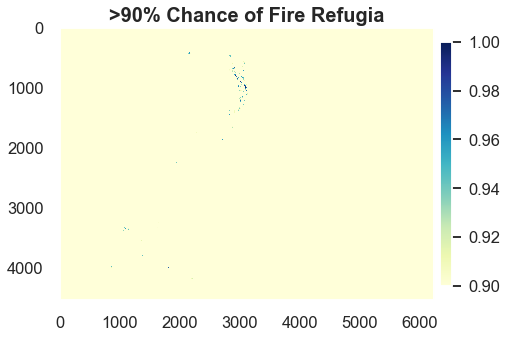

In [55]:
# open created raster file
m_result = rio.open(r"C:\Users\JGrov\Desktop\Fire_Refugia_CO\Raster Models\rf_model_v3_tpi.tif")

# reads the 2nd band which contains the results
m_result_arr = m_result.read(2)

# format and show results
plt.imshow(m_result_arr, cmap="YlGnBu", vmin=.9, vmax=1) # vmin and vmax change range of pixels to show
plt.title('>90% Chance of Fire Refugia', fontsize=20)
plt.colorbar(pad = 0.01, shrink=0.9)
plt.grid(False)

In [2]:
# load in burned fire refugia dataset
df = pd.read_csv(r"C:\Users\JGrov\Desktop\High_Elevation_Fire_Refugia\fire_perim_inter.csv")

# rename columns
df = df.rename(columns={'fireyear': 'Year', 'acres':'Acres'})

df

,Year,Acres
0,2003,64.144157
1,2010,180.632812
2,2010,41.456497
3,2010,12.088306
4,2010,0.882108
...,...,...
177,2020,7.733875
178,2013,1.020273
179,2020,1.020273
180,2013,0.299476


In [3]:
# group year column and sum acres and round
df = df.groupby(by=['Year']).sum().round({'Acres':2}).reset_index()

df

# create dataframe with years with no burned fire refugia and set acres to 0
df_2 = pd.DataFrame({'Year': [2000,2004,2007,2008,2009,2011,2014,2015,2017],
                     'Acres': [0,0,0,0,0,0,0,0,0]})

# append df_2 to df inorder to create a single dataframe of burned fr
df_burned_fr = df.append(df_2, ignore_index=True).sort_values(by=['Year'], ascending=True)

df_burned_fr

,Year,Acres
12,2000,0.00
0,2001,109.21
1,2002,8171.06
2,2003,64.14
13,2004,0.00
3,2005,7.76
4,2006,7.25
14,2007,0.00
15,2008,0.00
16,2009,0.00


In [4]:
# find total acres burned
df_burned_fr['Acres'].sum()

23746.46

In [5]:
# find sum of acres burned between 2010-2020
df_decade_2010 = df_burned_fr[(df_burned_fr['Year'] >= 2010)]

decade_2010_sum = df_decade_2010['Acres'].sum()
decade_2010_avg = round(df_decade_2010['Acres'].mean(), 2)

print(decade_2010_sum, decade_2010_avg )

15387.039999999999 1398.82


In [6]:
# find sum of acres burned between 2000-2010
df_decade_2000 = df_burned_fr[(df_burned_fr['Year'] <= 2010)]

decade_2000_sum = df_decade_2000['Acres'].sum()
decade_2000_avg = round(df_decade_2000['Acres'].mean(), 2)

print(decade_2000_sum, decade_2000_avg )

8594.48 781.32


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 <a list of 21 Text major ticklabel objects>)

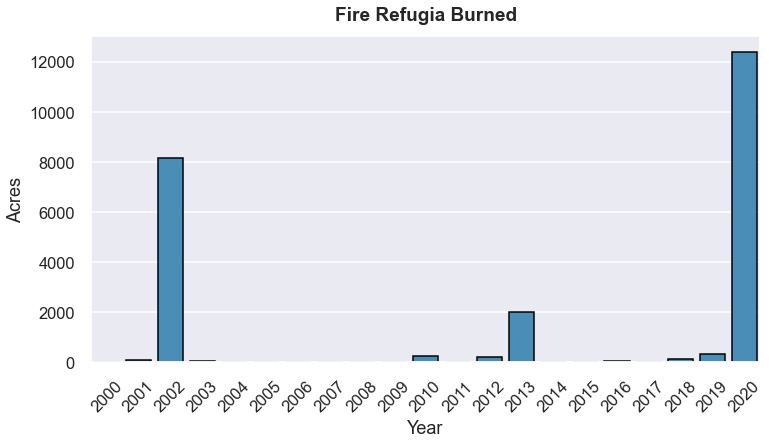

In [7]:
# plot burned fire refugia
plt.figure(figsize=(12,6))
sns.set(style='darkgrid')
sns.set_context('talk')

fig = sns.barplot(x="Year", y="Acres", data=df_burned_fr, color='#3792CB', edgecolor='black')

plt.title('Fire Refugia Burned',
          weight='bold',
          y=1.03).set_fontsize('19')
plt.xlabel('Year')
plt.ylabel('Acres')
plt.xticks(rotation=45)

In [8]:
# load in temp dataset to a dataframe
df_temp = pd.read_csv(r"C:\Users\JGrov\Desktop\Fire_Refugia_CO\Datafiles\temp.csv", usecols=['Year', 'Temperature (Degrees F)'])

# get average temp for plot
df_temp_2010 = df_temp[(df_temp['Year'] >= 2010)]
df_temp_2010_avg = round(df_temp_2010['Temperature (Degrees F)'].mean(), 2)

df_temp_2000 = df_temp[(df_temp['Year'] <= 2010)]
df_temp_2000_avg = round(df_temp_2000['Temperature (Degrees F)'].mean(), 2)

# load in precip dataset to a dataframe
df_precip = pd.read_csv(r"C:\Users\JGrov\Desktop\Fire_Refugia_CO\Datafiles\precip.csv", usecols=['Year', 'Precipitation (Inches)'])

# get average precip for plot
df_precip_2010 = df_precip[(df_precip['Year'] >= 2010)]
df_precip_2010_avg = round(df_precip_2010['Precipitation (Inches)'].mean(), 2)

df_precip_2000 = df_precip[(df_temp['Year'] <= 2010)]
df_precip_2000_avg = round(df_precip_2000['Precipitation (Inches)'].mean(), 2)

# load in burned acres dataset and rename columns
df_burned_acres = pd.read_csv(r"C:\Users\JGrov\Desktop\Fire_Refugia_CO\Datafiles\acres_burned.csv")
df_burned_acres = df_burned_acres.rename(columns={'Acres Burned': 'Acres'})

# get average burned acres for plot
df_burned_acres_2010 = df_burned_acres[(df_burned_acres['Year'] >= 2010)]
df_burned_acres_2010_avg = round(df_burned_acres_2010['Acres'].mean(), 2)

df_burned_acres_2000 = df_burned_acres[(df_burned_acres['Year'] <= 2010)]
df_burned_acres_2000_avg = round(df_burned_acres_2000['Acres'].mean(), 2)

print(df_burned_acres_2000_avg, df_burned_acres_2010_avg) 

65444.45 187618.0


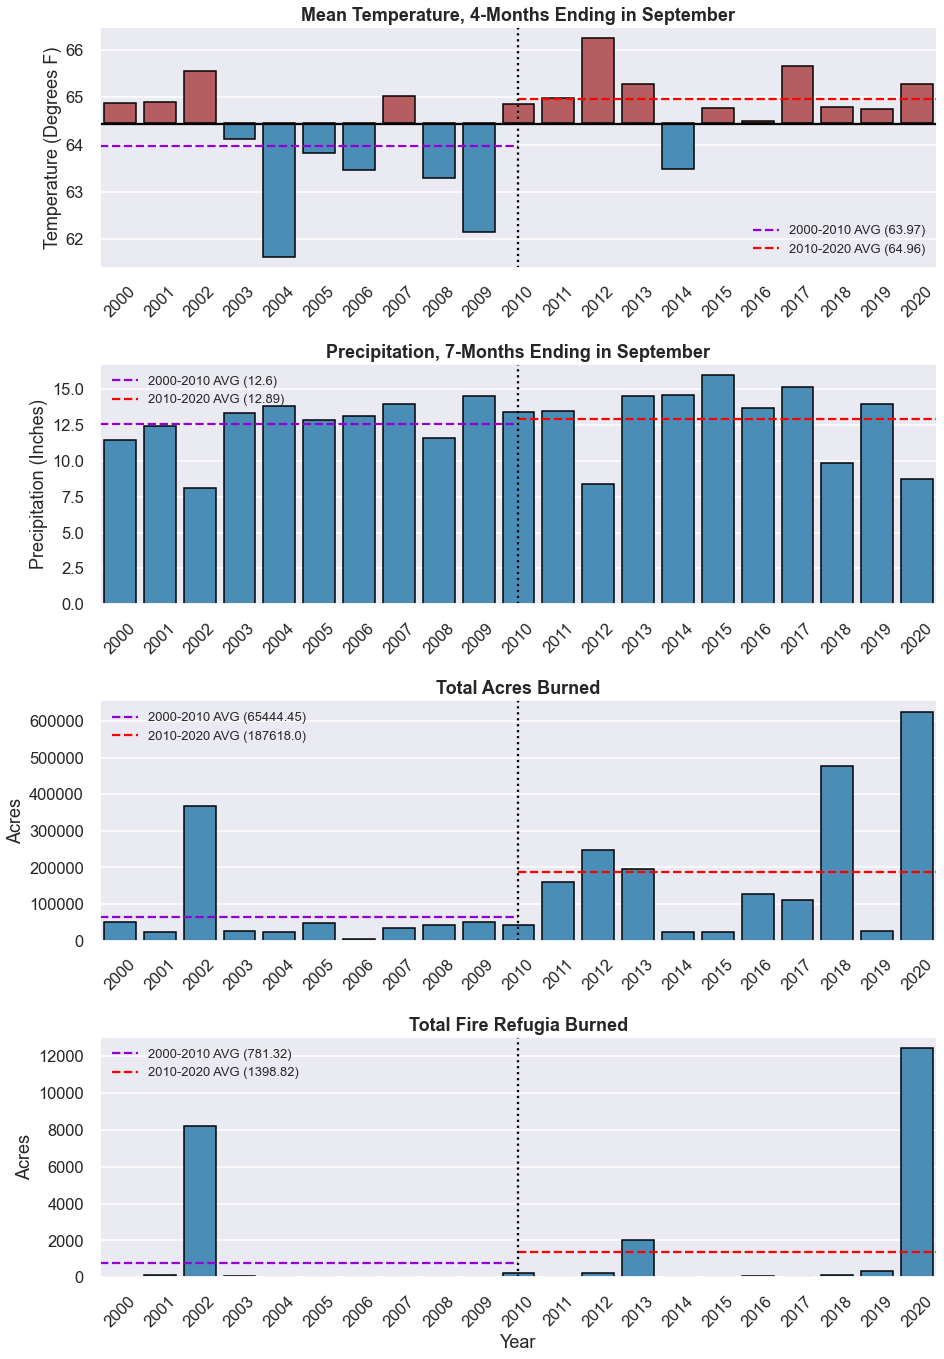

In [11]:
# calculate the mean temperature and subtract it from the dataset / create color pallete
mean = df_temp['Temperature (Degrees F)'].mean()
df_temp['Temperature (Degrees F)'] -= mean
palettes=["r" if x > mean else '#3792CB' for x in df_temp['Temperature (Degrees F)']]

sns.set(style='darkgrid')
sns.set_context('talk')

fig, axes = plt.subplots(nrows=4, figsize=(15,23))

# plots temp
sns.barplot(x='Year', y='Temperature (Degrees F)', data=df_temp, palette=palettes, edgecolor= 'black', ax=axes[0], bottom=64.45) \
    .set_title('Mean Temperature, 4-Months Ending in September', fontweight ="bold")
# plots horizontal line at 'bottom'
axes[0].axhline(64.44666666666667, ls='-', c='black') 
#plots average line
axes[0].axhline(df_temp_2000_avg, ls='--', xmin=0, xmax=0.50, c='#9400D3', label='2000-2010 AVG (' + str(df_temp_2000_avg) + ')') 
axes[0].axhline(df_temp_2010_avg, ls='--', xmin=.50, xmax=1, c='red',  label='2010-2020 AVG (' + str(df_temp_2010_avg) + ')') 
axes[0].legend(fontsize=13)

# plots precip
sns.barplot(x='Year', y='Precipitation (Inches)', data=df_precip, color='#3792CB', edgecolor= 'black', ax=axes[1]) \
    .set_title('Precipitation, 7-Months Ending in September', fontweight ="bold")
#plots average line
axes[1].axhline(df_precip_2000_avg, ls='--', xmin=0, xmax=0.50, c='#9400D3', label='2000-2010 AVG (' + str(df_precip_2000_avg) + ')') 
axes[1].axhline(df_precip_2010_avg, ls='--', xmin=.50, xmax=1, c='red', label='2010-2020 AVG (' + str(df_precip_2010_avg) + ')') 
axes[1].legend(fontsize=13)

# plots total acres burned
sns.barplot(x='Year', y='Acres', data=df_burned_acres, color='#3792CB', edgecolor= 'black', ax=axes[2]) \
    .set_title('Total Acres Burned', fontweight ="bold")
#plots average line
axes[2].axhline(df_burned_acres_2000_avg, ls='--', xmin=0, xmax=0.50, c='#9400D3', label='2000-2010 AVG (' + str(df_burned_acres_2000_avg) + ')') 
axes[2].axhline(df_burned_acres_2010_avg, ls='--', xmin=.50, xmax=1, c='red', label='2010-2020 AVG (' + str(df_burned_acres_2010_avg) + ')') 
axes[2].legend(fontsize=13)

# plots total refugia burned
sns.barplot(x='Year', y='Acres', data=df_burned_fr, color='#3792CB', edgecolor= 'black', ax=axes[3]) \
    .set_title('Total Fire Refugia Burned', fontweight ="bold")
#plots average line
axes[3].axhline(decade_2000_avg, ls='--', xmin=0, xmax=0.50, c='#9400D3', label='2000-2010 AVG (' + str(decade_2000_avg) + ')') 
axes[3].axhline(decade_2010_avg, ls='--', xmin=.50, xmax=1, c='red', label='2010-2020 AVG (' + str(decade_2010_avg) + ')') 
axes[3].legend(fontsize=13)

plt.subplots_adjust(hspace=.4)

# rotates all xticks in plots
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.axvline(10, ls='dotted', c='black')
    for ax in axes[:3]:
        ax.set_xlabel('')

In [20]:
# empty lists to be appened
years = []
acres = []
pct_brnds = []

# sets values for while loop
year = 2020
acres_brnd = decade_2010_sum
total_acres = 415984.70

# appends starting vlaues
years.append(year)
acres.append(acres_brnd)
pct_brnds.append(acres_brnd / total_acres * 100)

# sets the startiong degree
deg = 1

# while loop that appends values to lists
while acres[-1] < total_acres:
    year += 10
    years.append(year)
    
    # adds 1 degree every ten years
    deg += 1
    
    acres_brnd_10yr = deg * acres_brnd + acres[-1]
    acres.append(acres_brnd_10yr)
    
    pct_brnd = acres[-1] / total_acres * 100 
    pct_brnds.append(pct_brnd)

# creates dictionary form lits    
fr_brnd_dict = {'Year': years, 'Acres': acres, 'Percent Burned': pct_brnds}

# creates dataframe from dictionary and rounds dataframe
df_proj = pd.DataFrame(fr_brnd_dict)
df_proj = df_proj.round(2)

# replace the last values with max acres and 100% 
df_proj.replace(to_replace=430837.12, value=415984.70, inplace=True)
df_proj.replace(to_replace=103.57, value=100, inplace=True)

df_proj

,Year,Acres,Percent Burned
0,2020,15387.04,3.70
1,2030,46161.12,11.10
2,2040,92322.24,22.19
3,2050,153870.40,36.99
4,2060,230805.60,55.48
5,2070,323127.84,77.68
6,2080,415984.70,100.00


In [23]:
# empty lists to be appened
years_1 = []
acres_1 = []
pct_brnds_1 = []

# sets values for while loop
year_1 = 2020
acres_brnd_1 = df_burned_fr['Acres'].sum()
total_acres = 415984.70

# appends starting vlaues
years_1.append(year_1)
acres_1.append(acres_brnd_1)
pct_brnds_1.append(acres_brnd_1 / total_acres * 100)

# while loop that appends values to lists
while acres_1[-1] < total_acres:
    year_1 += 20
    years_1.append(year_1)
    
    acres_brnd_20yr = acres_1[-1] + acres_brnd_1
    acres_1.append(acres_brnd_20yr)
    
    pct_brnd_1 = acres_1[-1] / total_acres * 100
    pct_brnds_1.append(pct_brnd_1)

# creates dictionary form lits    
fr_brnd_dict_1 = {'Year': years_1, 'Acres': acres_1, 'Percent Burned': pct_brnds_1}

# creates dataframe from dictionary and rounds dataframe
df_proj_1 = pd.DataFrame(fr_brnd_dict_1)
df_proj_1 = df_proj_1.round(2)

# # replaces 182.67% with 100%
df_proj_1.replace(to_replace=427436.28, value=415984.70, inplace=True)
df_proj_1.replace(to_replace=102.75, value=100, inplace=True)

df_proj_1

,Year,Acres,Percent Burned
0,2020,23746.46,5.71
1,2040,47492.92,11.42
2,2060,71239.38,17.13
3,2080,94985.84,22.83
4,2100,118732.30,28.54
5,2120,142478.76,34.25
6,2140,166225.22,39.96
7,2160,189971.68,45.67
8,2180,213718.14,51.38
9,2200,237464.60,57.08


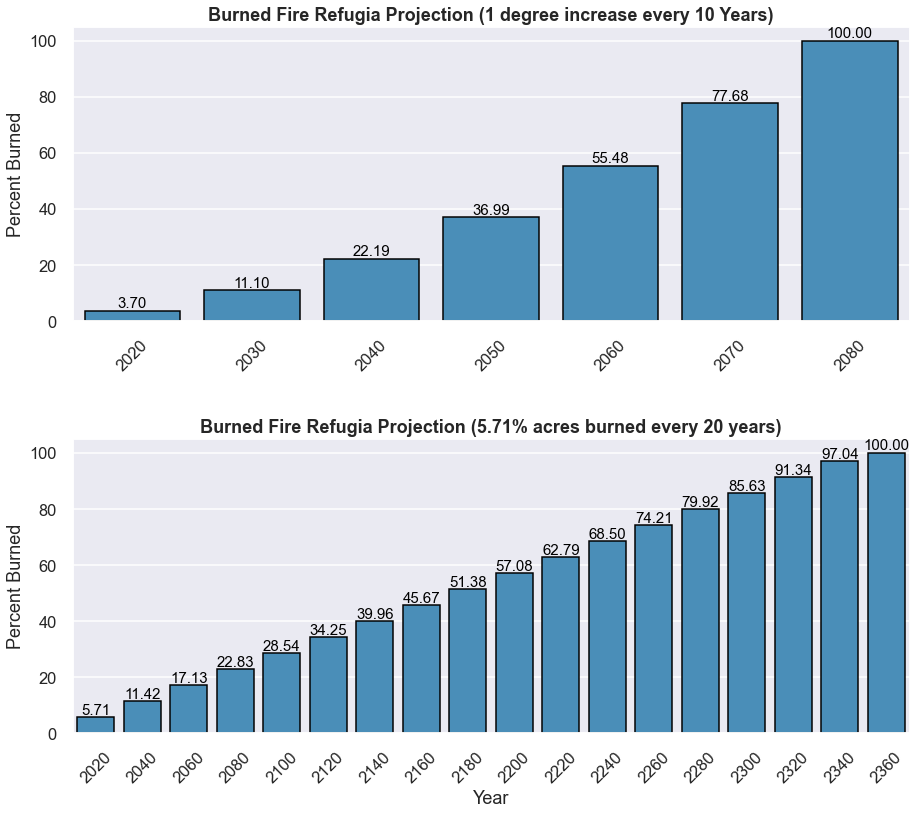

In [24]:
# sets figure style
sns.set(style='darkgrid')
sns.set_context('talk')

fig, axes = plt.subplots(nrows=2, figsize=(15,13))

# adds some extra space between plots
plt.subplots_adjust(hspace=.4)

# plots bar charts
sns.barplot(x="Year", y="Percent Burned", data=df_proj, color='#3792CB', edgecolor='black', ax=axes[0]) \
    .set_title('Burned Fire Refugia Projection (1 degree increase every 10 Years)', fontweight ="bold")

sns.barplot(x="Year", y="Percent Burned", data=df_proj_1, color='#3792CB', edgecolor='black', ax=axes[1]) \
    .set_title('Burned Fire Refugia Projection (5.71% acres burned every 20 years)', fontweight ="bold")

# rotates all xticks in plots
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    for ax in axes[:1]: # removes tick labels on all subplots except last one
        ax.set_xlabel('')

# # annotation ontop of bars
for p in axes[0].patches:
             axes[0].annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize='small', color='black', xytext=(0, 7),
                 textcoords='offset points')
for p in axes[1].patches:
             axes[1].annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize='small', color='black', xytext=(0, 7),
                 textcoords='offset points')